### Weather Station Clustering using DBSCAN & scikit-learn 
DBSCAN can be used here, for instance, to find the group of stations which show the same weather condition. As you can see, it not only finds different arbitrary shaped clusters, can find the denser part of data-centered samples by ignoring less-dense areas or noises.

In [1]:
import csv
import pandas as pd 
import numpy as np 

In [2]:
!wget -O weather-stations20140101-20141231.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/weather-stations20140101-20141231.csv

filename='weather-stations20140101-20141231.csv'
df = pd.read_csv(filename)
df.head()

--2020-05-03 16:58:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/weather-stations20140101-20141231.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response...200 OK
Length: 129821 (127K) [text/csv]
Saving to: ‘weather-stations20140101-20141231.csv’

weather-stations201 100%[===================>] 126.78K  --.-KB/s    in 0.04s   

2020-05-03 16:58:06 (2.79 MB/s) - ‘weather-stations20140101-20141231.csv’ saved [129821/129821]



,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573


**1. Data preprocessing**

In [3]:
#Here we need to clean the data, getting rid of null values in TM column and reset the index to avoid disorder.
df = df[pd.notnull(df["Tm"])]
df = df.reset_index(drop=True)
df.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0.0,NaN,13.1,0.0,1.9,...,8.0,NaN,NaN,12.0,NaN,NaN,NaN,258.6,0.0,1012710


**2. Visialization**

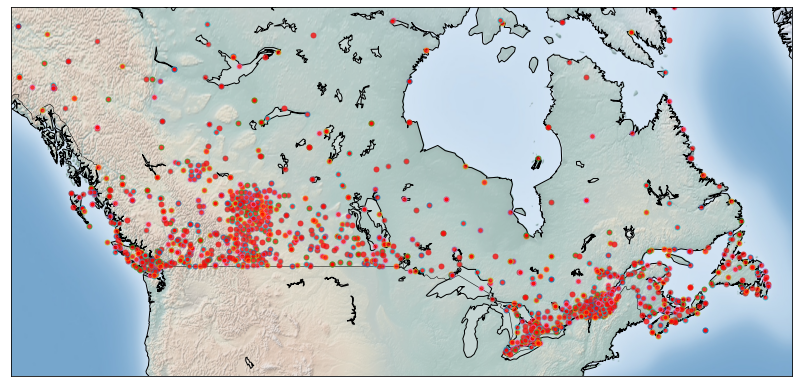

In [6]:
#Basemap does not do any plotting on it’s own, but provides the facilities to transform coordinates to a map projections.

#If error says:No module named 'mpl_toolkits.basemap', run: pip install --user https://github.com/matplotlib/basemap/archive/master.zip

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

llon=-140
ulon=-50
llat=40
ulat=65

df = df[(df['Long'] > llon) & (df['Long'] < ulon) & (df['Lat'] > llat) &(df['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(df.Long), np.asarray(df.Lat))
df['xm']= xs.tolist()
df['ym'] =ys.tolist()

#Visualization1
for index,row in df.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()

**3. Clustering of stations based on their location, mean, max, and min Temperature**

In [11]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

sklearn.utils.check_random_state(1000) 
Clus_dataSet = df[['xm','ym','Tx','Tm','Tn']] #pass it the Numpy array Clus_dataSet to find core samples of high density and expands clusters from them.
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

df[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)

,Stn_Name,Tx,Tm,Clus_Db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


**4. Visialization of cluster**

Cluster 0, Avg Temp: 6.221192052980132
Cluster 1, Avg Temp: 6.790000000000001
Cluster 2, Avg Temp: -0.49411764705882344
Cluster 3, Avg Temp: -13.87720930232558
Cluster 4, Avg Temp: -4.186274509803922
Cluster 5, Avg Temp: -16.301503759398496
Cluster 6, Avg Temp: -13.599999999999998
Cluster 7, Avg Temp: -9.753333333333334
Cluster 8, Avg Temp: -4.258333333333334


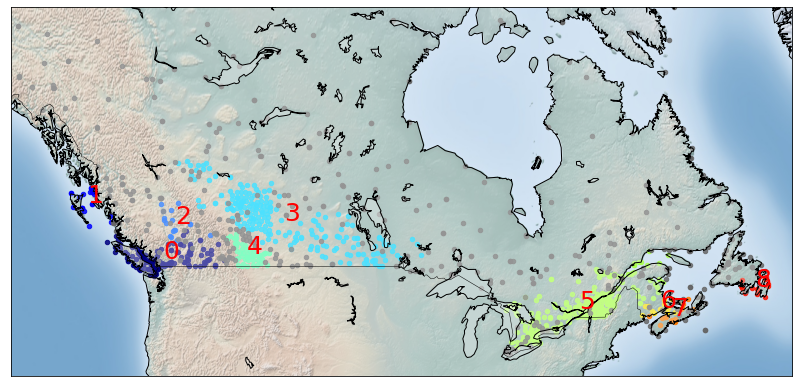

In [13]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = df[df.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))